# Newt Dataset Preparation
> This notebook is used to prepare the newt dataset for training and evaluation.

In [30]:
#| default_exp newt_dataset

In [31]:
#| eval: false
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import shutil
from pathlib import Path
from wildlife_datasets import datasets, analysis
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL.ExifTags import TAGS
from PIL import Image
import os
import exifread
from pymediainfo import MediaInfo

In [ ]:
# Set pandas display options to show all columns and wide output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [32]:
#| export
def download_kaggle_dataset(dataset_name, download_path):
    import os
    import kaggle

    if not os.path.exists(download_path):
        os.makedirs(download_path, exist_ok=True)
        kaggle.api.dataset_download_files(dataset_name, path=download_path, unzip=True)
        print(f"Dataset downloaded to {download_path}")
    else:
        print(f"Dataset already exists at {download_path}")

    return download_path

In [33]:
download_kaggle_dataset("mshahoyi/bar-hill-surveys", "./data/barhill-unprocessed")

Dataset already exists at ./data/barhill-unprocessed


'./data/barhill-unprocessed'

In [34]:
data_root = Path("./data/barhill-unprocessed")/'Bar Hill Surveys 2024'
walk = list(os.walk(data_root))
walk[:4]

[('data/barhill-unprocessed/Bar Hill Surveys 2024',
  ['Survey 5 06_06_24',
   'Survey 7 12_06_24',
   'Survey 2 10_05_24',
   'Survey 1 09_05_24',
   'Survey 6 07_06_24',
   'Survey 3 16_05_24',
   'Survey 8 13_06_24',
   'Survey 4 17_05_24'],
  ['Bar Hill GCN Survey Results 2024.xlsx',
   'ARU Research poster A1 (003) Ecoacoustics researching at Cambridge crematorium_edit (002).png',
   'GCN Surveys at Cambridge Crematorium 2024.docx']),
 ('data/barhill-unprocessed/Bar Hill Surveys 2024/Survey 5 06_06_24',
  ['Pond 4', 'Pond 3', 'Pond 2'],
  []),
 ('data/barhill-unprocessed/Bar Hill Surveys 2024/Survey 5 06_06_24/Pond 4',
  ['GCN1-P4-S5'],
  []),
 ('data/barhill-unprocessed/Bar Hill Surveys 2024/Survey 5 06_06_24/Pond 4/GCN1-P4-S5',
  [],
  ['IMG_3558.MOV',
   'IMG_3551.MOV',
   'IMG_3553.MOV',
   'IMG_3555.JPEG',
   'IMG_3556.JPEG',
   'IMG_3556.MOV',
   'IMG_3554.JPEG',
   'IMG_3557.JPEG',
   'IMG_3552.MOV',
   'IMG_3551.JPEG',
   'IMG_3557.MOV',
   'IMG_3552.JPEG',
   'IMG_3555.MO

In [35]:
gcns = [x for x in walk if 'gcn' in os.path.basename(x[0]).lower()]
gcns[:2]

[('data/barhill-unprocessed/Bar Hill Surveys 2024/Survey 5 06_06_24/Pond 4/GCN1-P4-S5',
  [],
  ['IMG_3558.MOV',
   'IMG_3551.MOV',
   'IMG_3553.MOV',
   'IMG_3555.JPEG',
   'IMG_3556.JPEG',
   'IMG_3556.MOV',
   'IMG_3554.JPEG',
   'IMG_3557.JPEG',
   'IMG_3552.MOV',
   'IMG_3551.JPEG',
   'IMG_3557.MOV',
   'IMG_3552.JPEG',
   'IMG_3555.MOV',
   'IMG_3553.JPEG',
   'IMG_3554.MOV',
   'IMG_3558.JPEG']),
 ('data/barhill-unprocessed/Bar Hill Surveys 2024/Survey 5 06_06_24/Pond 3/GCN2-P3-S5',
  [],
  ['IMG_3564.JPEG',
   'IMG_3565.MOV',
   'IMG_3565.JPEG',
   'IMG_3563.MOV',
   'IMG_3561.MOV',
   'IMG_3566.JPEG',
   'IMG_3564.MOV',
   'IMG_3562.MOV',
   'IMG_3561.JPEG',
   'IMG_3563.JPEG',
   'IMG_3566.MOV',
   'IMG_3562.JPEG'])]

In [36]:
data = [(os.path.basename(root), list(map(lambda f: os.path.join(root, f), files))) for root, _, files in gcns]

dict(data[:2])

{'GCN1-P4-S5': ['data/barhill-unprocessed/Bar Hill Surveys 2024/Survey 5 06_06_24/Pond 4/GCN1-P4-S5/IMG_3558.MOV',
  'data/barhill-unprocessed/Bar Hill Surveys 2024/Survey 5 06_06_24/Pond 4/GCN1-P4-S5/IMG_3551.MOV',
  'data/barhill-unprocessed/Bar Hill Surveys 2024/Survey 5 06_06_24/Pond 4/GCN1-P4-S5/IMG_3553.MOV',
  'data/barhill-unprocessed/Bar Hill Surveys 2024/Survey 5 06_06_24/Pond 4/GCN1-P4-S5/IMG_3555.JPEG',
  'data/barhill-unprocessed/Bar Hill Surveys 2024/Survey 5 06_06_24/Pond 4/GCN1-P4-S5/IMG_3556.JPEG',
  'data/barhill-unprocessed/Bar Hill Surveys 2024/Survey 5 06_06_24/Pond 4/GCN1-P4-S5/IMG_3556.MOV',
  'data/barhill-unprocessed/Bar Hill Surveys 2024/Survey 5 06_06_24/Pond 4/GCN1-P4-S5/IMG_3554.JPEG',
  'data/barhill-unprocessed/Bar Hill Surveys 2024/Survey 5 06_06_24/Pond 4/GCN1-P4-S5/IMG_3557.JPEG',
  'data/barhill-unprocessed/Bar Hill Surveys 2024/Survey 5 06_06_24/Pond 4/GCN1-P4-S5/IMG_3552.MOV',
  'data/barhill-unprocessed/Bar Hill Surveys 2024/Survey 5 06_06_24/Pond 

In [37]:
metadata = pd.DataFrame(data).explode(1)
metadata.columns = ["reference_id", "file_path"]
metadata.shape

(2504, 2)

In [38]:
metadata.head()

,identity,file_path
0,GCN1-P4-S5,data/barhill-unprocessed/Bar Hill Surveys 2024...
0,GCN1-P4-S5,data/barhill-unprocessed/Bar Hill Surveys 2024...
0,GCN1-P4-S5,data/barhill-unprocessed/Bar Hill Surveys 2024...
0,GCN1-P4-S5,data/barhill-unprocessed/Bar Hill Surveys 2024...
0,GCN1-P4-S5,data/barhill-unprocessed/Bar Hill Surveys 2024...


In [39]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2504 entries, 0 to 206
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   identity   2504 non-null   object
 1   file_path  2504 non-null   object
dtypes: object(2)
memory usage: 58.7+ KB


In [40]:
metadata['file_name'] = metadata['file_path'].apply(lambda x: os.path.basename(x))
metadata['is_video'] = metadata['file_name'].apply(lambda x: 'mov' in x.lower())
metadata.head()

,identity,file_path,file_name,is_video
0,GCN1-P4-S5,data/barhill-unprocessed/Bar Hill Surveys 2024...,IMG_3558.MOV,True
0,GCN1-P4-S5,data/barhill-unprocessed/Bar Hill Surveys 2024...,IMG_3551.MOV,True
0,GCN1-P4-S5,data/barhill-unprocessed/Bar Hill Surveys 2024...,IMG_3553.MOV,True
0,GCN1-P4-S5,data/barhill-unprocessed/Bar Hill Surveys 2024...,IMG_3555.JPEG,False
0,GCN1-P4-S5,data/barhill-unprocessed/Bar Hill Surveys 2024...,IMG_3556.JPEG,False


In [ ]:
mapper = {reference_id: i+1 for i, reference_id in enumerate(metadata.reference_id.unique())}
metadata['identity'] = metadata.reference_id.map(mapper)
metadata

In [ ]:
output_dir = Path("./data/gcns-processed")
shutil.rmtree(output_dir, ignore_errors=True)
Path(output_dir).mkdir(exist_ok=True)

In [44]:
class UnprocessedNewtsDataset(datasets.WildlifeDataset):
    def create_catalogue(self) -> pd.DataFrame:
        return metadata[~metadata.is_video].rename(columns={"file_name": "image_name", "file_path": "path"})

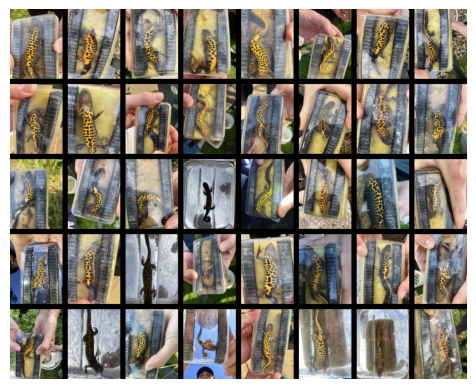

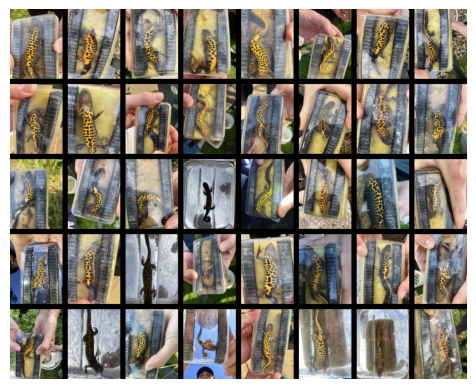

In [45]:
dataset = UnprocessedNewtsDataset('.')
plt.figure(figsize=(7, 7))
dataset.plot_grid()
plt.savefig(output_dir/'grid.png')

# Split the dataset

Number of identitites            204
Number of all animals            1252
Number of animals with one image 0
Number of unidentified animals   0


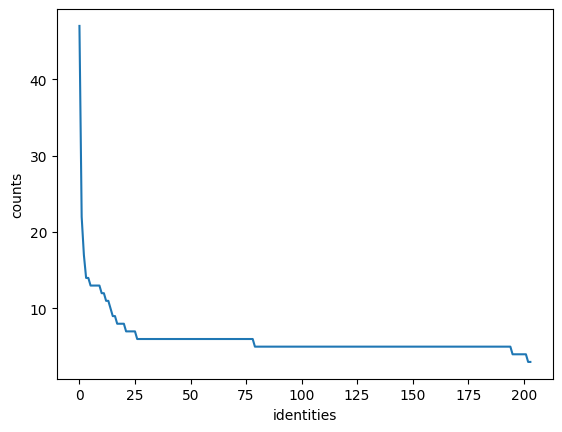

In [46]:
plt.figure(figsize=(3.5, 3))
plt.title("Number of images per identity")
analysis.display_statistics(dataset.df)
plt.savefig(output_dir/'distribution.png')

In [47]:
n_files = len(metadata)
n_images = len(metadata[~metadata.is_video])
n_videos = len(metadata[metadata.is_video])
n_identities = len(metadata.identity.unique())
stats = {
    "n_files": n_files,
    "n_images": n_images,
    "n_videos": n_videos,
    "n_identities": n_identities
}
pd.DataFrame(stats, index=[0]).to_csv(output_dir/'statistics.csv', index=False)
stats

Split: time-unaware disjoint-set
Samples: train/test/unassigned/total = 625/627/0/1252
Classes: train/test/unassigned/total = 110/94/0/204
Samples: train only/test only        = 625/627
Classes: train only/test only/joint  = 110/94/0

Fraction of train set     = 49.92%
Fraction of test set only = 50.08%
Split: time-unaware disjoint-set
Samples: train/test/unassigned/total = 312/315/0/627
Classes: train/test/unassigned/total = 50/44/0/94
Samples: train only/test only        = 312/315
Classes: train only/test only/joint  = 50/44/0

Fraction of train set     = 49.76%
Fraction of test set only = 50.24%
Train: 625, Test: 312, Validation: 315


In [48]:
metadata_new = metadata.copy().reset_index(drop=True)

for i, row in tqdm(metadata_new.iterrows()):
    new_path = Path('newts')/str(row.identity)/row.file_name
    Path(output_dir/new_path).parent.mkdir(parents=True, exist_ok=True)
    shutil.copy(row.file_path, output_dir/new_path)
    metadata_new.loc[i, 'file_path'] = new_path

,identity,path,image_name,is_video
0,GCN1-P1-S2,data/barhill-unprocessed/Bar Hill Surveys 2024...,IMG_2312.JPEG,False
1,GCN1-P1-S2,data/barhill-unprocessed/Bar Hill Surveys 2024...,IMG_2310.JPEG,False
2,GCN1-P1-S2,data/barhill-unprocessed/Bar Hill Surveys 2024...,IMG_2309.JPEG,False
3,GCN1-P1-S2,data/barhill-unprocessed/Bar Hill Surveys 2024...,IMG_2311.JPEG,False
4,GCN1-P1-S2,data/barhill-unprocessed/Bar Hill Surveys 2024...,IMG_2313.JPEG,False


# Extract the images time of capture

In [49]:
def get_image_creation_date(image_path):
    with open(image_path, 'rb') as f:
        tags = exifread.process_file(f, stop_tag="EXIF DateTimeOriginal")
        date_tag = tags.get("EXIF DateTimeOriginal")
        if date_tag:
            return pd.to_datetime(str(date_tag), format='%Y:%m:%d %H:%M:%S', utc=True)
    return None

def get_video_creation_date(video_path):
    media_info = MediaInfo.parse(video_path)
    for track in media_info.tracks:
        if track.track_type == "General":
            date = (
                track.tagged_date or
                track.recorded_date or
                track.encoded_date
            )
            if date:
                return pd.to_datetime(date).floor('s')
    return None

def get_creation_date(row):
    file_path = os.path.join(output_dir, row.file_path)
    is_video = row.is_video

    if is_video: return get_video_creation_date(file_path)
    return get_image_creation_date(file_path)

In [50]:
metadata_new['creation_date'] = pd.NA

for i, row in tqdm(metadata_new.iterrows(), total=len(metadata_new)):
    creation_date = get_creation_date(row)
    metadata_new.at[i, 'creation_date'] = creation_date

In [51]:
metadata_new

2503it [00:06, 380.40it/s]


,identity,file_path,file_name,is_video,split
0,GCN1-P4-S5,test/GCN1-P4-S5/IMG_3558.JPEG,IMG_3558.MOV,True,test
0,GCN1-P4-S5,test/GCN1-P4-S5/IMG_3558.JPEG,IMG_3551.MOV,True,test
0,GCN1-P4-S5,test/GCN1-P4-S5/IMG_3558.JPEG,IMG_3553.MOV,True,test
0,GCN1-P4-S5,test/GCN1-P4-S5/IMG_3558.JPEG,IMG_3555.JPEG,False,test
0,GCN1-P4-S5,test/GCN1-P4-S5/IMG_3558.JPEG,IMG_3556.JPEG,False,test


In [ ]:
metadata_new.to_csv(output_dir/'metadata.csv', index=False)
metadata_new

# Upload to Kaggle

In [ ]:
#| export

def upload_to_kaggle(user_id, title, id, licenses, keywords, dataset_dir):
    import json
    import subprocess
    import os
    from pathlib import Path

    dataset_dir = Path(dataset_dir)
    original_cwd = os.getcwd()

    try:
        # The 'id' in metadata must be in the format 'user_id/dataset_id'
        full_dataset_id = f"{user_id}/{id}"

        # Create dataset metadata for Kaggle
        kaggle_metadata = {
            "title": title,
            "id": full_dataset_id,
            "licenses": licenses,
            "keywords": keywords,
        }
        
        # Write Kaggle dataset metadata
        with open(dataset_dir / "dataset-metadata.json", "w") as f:
            json.dump(kaggle_metadata, f, indent=2)
        
        print("Checking if dataset exists...")
        
        # Check if dataset exists
        check_result = subprocess.run(
            ["kaggle", "datasets", "list", "--user", user_id, "--search", id],
            capture_output=True, text=True
        )
        
        dataset_exists = id in check_result.stdout

        os.chdir(dataset_dir)
        
        print(f"Current directory: {os.getcwd()}")
        print(f"Files to upload: {list(Path('.').iterdir())}")
        
        command = []
        if dataset_exists:
            print("Dataset exists, updating...")
            command = [
                "kaggle", "datasets", "version",
                "-p", ".",
                "-m", "Updated with new dataset",
                "--dir-mode", "zip"
            ]
        else:
            print("Dataset does not exist, creating new...")
            command = [
                "kaggle", "datasets", "create",
                "-p", ".",
                "--dir-mode", "zip"
            ]
        
        result = subprocess.run(command, capture_output=True, text=True, check=True)
        print("✅ Dataset operation successful!")
        print("Output:", result.stdout)

        print(f"\nDataset available at: https://www.kaggle.com/datasets/{full_dataset_id}")
        
    except subprocess.CalledProcessError as e:
        print(f"❌ Error during Kaggle CLI command.")
        print("--- STDERR ---")
        print(e.stderr)
        print("--- STDOUT ---")
        print(e.stdout)
        raise e
    except Exception as e:
        print(f"❌ An unexpected error occurred: {str(e)}")
        raise e
    finally:
        os.chdir(original_cwd)

In [ ]:
upload_to_kaggle(user_id="mshahoyi",
                title="Barhill Great Crested Newts", 
                id="barhill-newts-all", 
                licenses=[{"name": "CC0-1.0"}], 
                keywords=["biology", "computer-vision", "animals", "great crested newts"], 
                dataset_dir="./data/gcns-processed")

In [29]:
import nbdev; nbdev.nbdev_export()